## Modelling with NN
I will attempt a deep NN with keras on the processed WNV data and see if it performs better than the XG Boost model. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
X_train = pd.read_csv('X_train.csv',index_col = 0).to_numpy()
X_test = pd.read_csv('X_test.csv',index_col = 0).to_numpy()
y_train = pd.read_csv('y_train.csv',index_col = 0).to_numpy()
y_test = pd.read_csv('y_test.csv',index_col = 0).to_numpy()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3692, 12)
(924, 12)
(3692, 1)
(924, 1)


Split Test set into validation and test sets.  Validation will be used to ensure model is not overfit.  Testing set will be used for assesing the true predictive power of the model.  

In [4]:
X_test,X_vali,y_test,y_vali = train_test_split(X_test,y_test,\
                                                  test_size = .5,\
                                                  stratify = y_test)

In [5]:
print(X_train.shape)
print(X_vali.shape)
print(X_test.shape)
print(y_train.shape)
print(y_vali.shape)
print(y_test.shape)

(3692, 12)
(462, 12)
(462, 12)
(3692, 1)
(462, 1)
(462, 1)


### Save datasets as Tensors

In [6]:
np.savez('Train_tensor',inputs=X_train,targets=y_train)
np.savez('Validation_tensor',inputs=X_vali,targets=y_vali)
np.savez('Test_tensor',inputs=X_test,targets=y_test)


Reload the data.  For future changes I can skip the cells above in this notebook. 

In [7]:
import numpy as np

In [8]:
### Reload data
npz = np.load('Train_tensor.npz')
train_inputs = npz['inputs'].astype(np.float)
train_targets = npz['targets'].astype(np.int)

npz = np.load('Validation_tensor.npz')
validation_inputs = npz['inputs'].astype(np.float)
validation_targets = npz['targets'].astype(np.int)

npz = np.load('Test_tensor.npz')
test_inputs = npz['inputs'].astype(np.float)
test_targets = npz['targets'].astype(np.int)

In [9]:
### For plotting

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

## Build the model

In [10]:
import tensorflow as tf

In [11]:
batch_size = 100
epochs = 100

width = 50
depth = 2

output_size = 1

activation = 'relu'

patience = 2

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,\
                                       restore_best_weights = True)

model = tf.keras.Sequential()

for _ in range(depth):
    model.add(tf.keras.layers.Dense(width, activation = activation))

model.add(tf.keras.layers.Dense(output_size, activation = 'sigmoid'))

model.compile(optimizer = 'Adam', loss = tf.keras.losses.BinaryCrossentropy(),\
             metrics = metrics)


model_hist = model.fit(train_inputs, train_targets, batch_size=batch_size,\
         epochs = epochs, validation_data = (validation_inputs,validation_targets),\
         verbose=2)



Epoch 1/100
37/37 - 2s - loss: 0.4158 - accuracy: 0.9066 - precision: 0.0889 - recall: 0.0130 - auc: 0.4520 - prc: 0.0741 - val_loss: 0.3254 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4542 - val_prc: 0.0840
Epoch 2/100
37/37 - 0s - loss: 0.2844 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6217 - prc: 0.1237 - val_loss: 0.2764 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6812 - val_prc: 0.1444
Epoch 3/100
37/37 - 0s - loss: 0.2548 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7628 - prc: 0.1857 - val_loss: 0.2601 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7455 - val_prc: 0.2285
Epoch 4/100
37/37 - 0s - loss: 0.2444 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7906 - prc: 0.2296 - val_loss: 0.2565 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 

Epoch 34/100
37/37 - 0s - loss: 0.2135 - accuracy: 0.9179 - precision: 0.5472 - recall: 0.0942 - auc: 0.8591 - prc: 0.3424 - val_loss: 0.2472 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8195 - val_prc: 0.3605
Epoch 35/100
37/37 - 0s - loss: 0.2136 - accuracy: 0.9187 - precision: 0.5800 - recall: 0.0942 - auc: 0.8582 - prc: 0.3435 - val_loss: 0.2485 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8225 - val_prc: 0.3243
Epoch 36/100
37/37 - 0s - loss: 0.2125 - accuracy: 0.9185 - precision: 0.5636 - recall: 0.1006 - auc: 0.8612 - prc: 0.3546 - val_loss: 0.2476 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8222 - val_prc: 0.3380
Epoch 37/100
37/37 - 0s - loss: 0.2128 - accuracy: 0.9196 - precision: 0.6170 - recall: 0.0942 - auc: 0.8591 - prc: 0.3492 - val_loss: 0.2487 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8236 - val_prc: 0.3299
Epoch 38/100
37/

Epoch 68/100
37/37 - 0s - loss: 0.2079 - accuracy: 0.9201 - precision: 0.6066 - recall: 0.1201 - auc: 0.8677 - prc: 0.3595 - val_loss: 0.2660 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8280 - val_prc: 0.3416
Epoch 69/100
37/37 - 0s - loss: 0.2068 - accuracy: 0.9179 - precision: 0.5455 - recall: 0.0974 - auc: 0.8709 - prc: 0.3651 - val_loss: 0.2658 - val_accuracy: 0.9264 - val_precision: 0.6667 - val_recall: 0.2105 - val_auc: 0.8290 - val_prc: 0.3480
Epoch 70/100
37/37 - 0s - loss: 0.2063 - accuracy: 0.9196 - precision: 0.5775 - recall: 0.1331 - auc: 0.8710 - prc: 0.3741 - val_loss: 0.2683 - val_accuracy: 0.9242 - val_precision: 0.6364 - val_recall: 0.1842 - val_auc: 0.8235 - val_prc: 0.3387
Epoch 71/100
37/37 - 0s - loss: 0.2065 - accuracy: 0.9201 - precision: 0.6140 - recall: 0.1136 - auc: 0.8703 - prc: 0.3662 - val_loss: 0.2706 - val_accuracy: 0.9156 - val_precision: 0.4000 - val_recall: 0.0526 - val_auc: 0.8284 - val_prc: 0.3396
Epoch 72/100
37/

In [12]:
results = model.evaluate(validation_inputs, validation_targets,\
                         batch_size = batch_size, verbose = 0)

In [13]:
for m,r in zip(model.metrics_names,results):
    print(str(m)+': {:.3f}'.format(r))

loss: 0.289
accuracy: 0.924
precision: 0.636
recall: 0.184
auc: 0.815
prc: 0.319


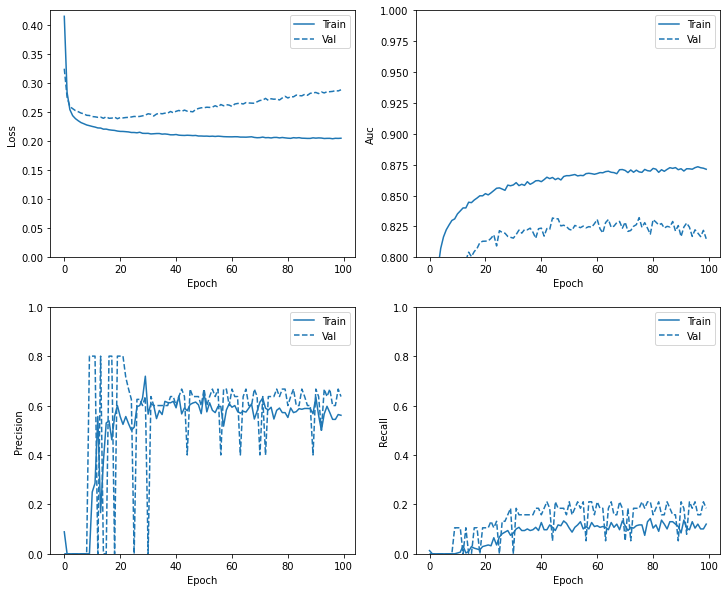

In [14]:
plot_metrics(model_hist)

Because the data set is imbalanced I will update the inital weights of the final layer. This should help with accuracy.  The first iteration of the NN should have a lower loss function value.

In [15]:
pos = train_targets.sum()
print(pos)
neg = np.sum(train_targets==0)
print(neg)

308
3384


Correct initial bias is $ sigmoid(x) = #pos/(#pos + #neg) $ 

which is $ = loge(#pos/#neg) $

In [16]:
inital_bias_output_layer = np.array([np.log(pos/neg)])
inital_bias_output_layer

array([-2.39671394])

In [17]:
batch_size = 100
epochs = 100

width = 50
depth = 2

output_size = 1

activation = 'relu'

patience = 2

### Set inital weights of last NN layer
inital_bias_output_layer = np.array([np.log(pos/neg)])
inital_bias_output_layer = tf.keras.initializers.Constant(inital_bias_output_layer)


metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,\
                                       restore_best_weights = True)

model = tf.keras.Sequential()

for _ in range(depth):
    model.add(tf.keras.layers.Dense(width, activation = activation))

model.add(tf.keras.layers.Dense(output_size, activation = 'sigmoid',
                               bias_initializer = inital_bias_output_layer))

model.compile(optimizer = 'Adam', loss = tf.keras.losses.BinaryCrossentropy(),\
             metrics = metrics)


model_hist = model.fit(train_inputs, train_targets, batch_size=batch_size,\
         epochs = epochs, validation_data = (validation_inputs,validation_targets),\
         verbose=2)



Epoch 1/100
37/37 - 2s - loss: 0.2671 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7313 - prc: 0.1829 - val_loss: 0.2628 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7274 - val_prc: 0.1887
Epoch 2/100
37/37 - 0s - loss: 0.2471 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7914 - prc: 0.2348 - val_loss: 0.2506 - val_accuracy: 0.9177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7640 - val_prc: 0.2735
Epoch 3/100
37/37 - 0s - loss: 0.2376 - accuracy: 0.9166 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8159 - prc: 0.2634 - val_loss: 0.2438 - val_accuracy: 0.9242 - val_precision: 0.8000 - val_recall: 0.1053 - val_auc: 0.7810 - val_prc: 0.3088
Epoch 4/100
37/37 - 0s - loss: 0.2327 - accuracy: 0.9174 - precision: 0.6000 - recall: 0.0292 - auc: 0.8281 - prc: 0.2731 - val_loss: 0.2427 - val_accuracy: 0.9242 - val_precision: 0.8000 - val_recall: 0.1053 - val_auc: 0.784

Epoch 35/100
37/37 - 0s - loss: 0.2095 - accuracy: 0.9196 - precision: 0.6000 - recall: 0.1071 - auc: 0.8664 - prc: 0.3535 - val_loss: 0.2517 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8314 - val_prc: 0.3521
Epoch 36/100
37/37 - 0s - loss: 0.2098 - accuracy: 0.9198 - precision: 0.6250 - recall: 0.0974 - auc: 0.8655 - prc: 0.3473 - val_loss: 0.2540 - val_accuracy: 0.9242 - val_precision: 0.6364 - val_recall: 0.1842 - val_auc: 0.8287 - val_prc: 0.3353
Epoch 37/100
37/37 - 0s - loss: 0.2097 - accuracy: 0.9185 - precision: 0.5574 - recall: 0.1104 - auc: 0.8667 - prc: 0.3544 - val_loss: 0.2546 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8276 - val_prc: 0.3299
Epoch 38/100
37/37 - 0s - loss: 0.2098 - accuracy: 0.9187 - precision: 0.5741 - recall: 0.1006 - auc: 0.8658 - prc: 0.3511 - val_loss: 0.2568 - val_accuracy: 0.9242 - val_precision: 0.6364 - val_recall: 0.1842 - val_auc: 0.8260 - val_prc: 0.3330
Epoch 39/100
37/

Epoch 69/100
37/37 - 0s - loss: 0.2062 - accuracy: 0.9185 - precision: 0.5479 - recall: 0.1299 - auc: 0.8710 - prc: 0.3599 - val_loss: 0.2760 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8278 - val_prc: 0.3478
Epoch 70/100
37/37 - 0s - loss: 0.2059 - accuracy: 0.9185 - precision: 0.5636 - recall: 0.1006 - auc: 0.8714 - prc: 0.3641 - val_loss: 0.2784 - val_accuracy: 0.9156 - val_precision: 0.4000 - val_recall: 0.0526 - val_auc: 0.8267 - val_prc: 0.3534
Epoch 71/100
37/37 - 0s - loss: 0.2058 - accuracy: 0.9193 - precision: 0.5862 - recall: 0.1104 - auc: 0.8714 - prc: 0.3664 - val_loss: 0.2774 - val_accuracy: 0.9221 - val_precision: 0.6000 - val_recall: 0.1579 - val_auc: 0.8281 - val_prc: 0.3614
Epoch 72/100
37/37 - 0s - loss: 0.2053 - accuracy: 0.9185 - precision: 0.5614 - recall: 0.1039 - auc: 0.8703 - prc: 0.3627 - val_loss: 0.2795 - val_accuracy: 0.9242 - val_precision: 0.6364 - val_recall: 0.1842 - val_auc: 0.8245 - val_prc: 0.3388
Epoch 73/100
37/

Initializing the bias in the last layer of the NN results in a lower loss in the first epoch and a higher validation accuracy

In [18]:
results = model.evaluate(validation_inputs, validation_targets,\
                         batch_size = batch_size, verbose = 0)

In [19]:
for m,r in zip(model.metrics_names,results):
    print(str(m)+': {:.3f}'.format(r))

loss: 0.294
accuracy: 0.924
precision: 0.636
recall: 0.184
auc: 0.826
prc: 0.345


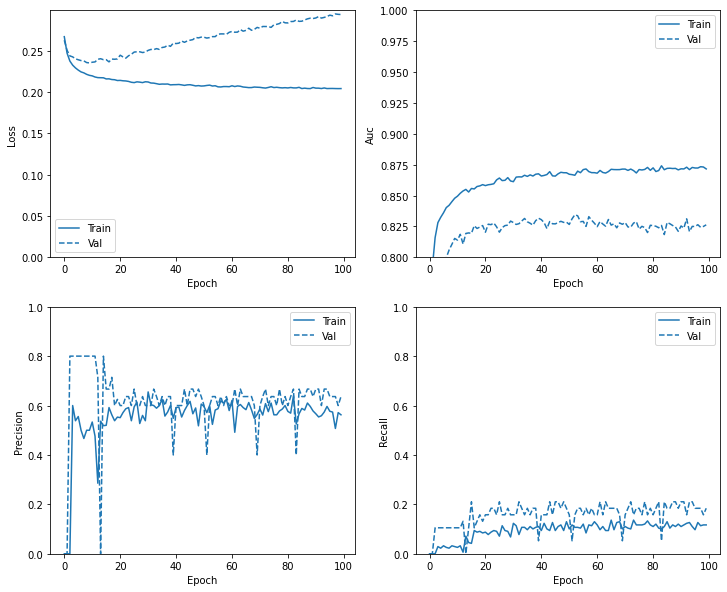

In [20]:
plot_metrics(model_hist)

The model metrics are a little better before the model starts to over fit to the training data
___
Now I will address the class imbalance by adjust the class weights.


In [21]:
total = pos + neg
w8_neg = (1/neg) * (total / 2)
w8_pos = (1/pos) * (total / 2)
print('Negative W8:',  w8_neg)
print('Positive W8:', w8_pos)

Negative W8: 0.5455082742316785
Positive W8: 5.993506493506494


In [22]:
class_w8s = {0:w8_neg, 1:w8_pos}

In [23]:
batch_size = 100
epochs = 100

width = 50
depth = 2

output_size = 1

activation = 'relu'

patience = 2

inital_bias_output_layer = np.array([np.log(pos/neg)])
inital_bias_output_layer = tf.keras.initializers.Constant(inital_bias_output_layer)


metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,\
                                       restore_best_weights = True)

model = tf.keras.Sequential()

for _ in range(depth):
    model.add(tf.keras.layers.Dense(width, activation = activation))

model.add(tf.keras.layers.Dense(output_size, activation = 'sigmoid',\
                               bias_initializer=inital_bias_output_layer))

model.compile(optimizer = 'Adam', loss = tf.keras.losses.BinaryCrossentropy(),\
             metrics = metrics)


model_hist = model.fit(train_inputs, train_targets, batch_size=batch_size,\
         epochs = epochs, validation_data = (validation_inputs,validation_targets),\
         class_weight = class_w8s,\
         verbose=2)



Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
37/37 - 3s - loss: 0.9376 - accuracy: 0.8860 - precision: 0.1401 - recall: 0.0714 - auc: 0.5272 - prc: 0.0993 - val_loss: 0.5376 - val_accuracy: 0.8009 - val_precision: 0.1625 - val_recall: 0.3421 - val_auc: 0.6274 - val_prc: 0.1587
Epoch 2/100
37/37 - 0s - loss: 0.6677 - accuracy: 0.7172 - precision: 0.1413 - recall: 0.4708 - auc: 0.6710 - prc: 0.1500 - val_loss: 0.5716 - val_accuracy: 0.6948 - val_precision: 0.1448 - val_recall: 0.5526 - val_auc: 0.7461 - val_prc: 0.2182
Epoch 3/100
37/37 - 0s - loss: 0.5855 - accuracy: 0.7080 - precision: 0.1818 - recall: 0.7143 - auc: 0.7669 - prc: 0.2019 - val_loss: 0.5280 - val_accuracy: 0.6991 - val_precision: 0.1656 - val_recall: 0.6579 - val_auc: 0.7780 - val_prc: 0.2137
Epoch 4/100
37/37 - 0s - loss: 0.5465 - accuracy: 0.7189 - precision: 0.1968 - recall: 0.7695 - auc: 0.7957 - prc: 0.2274 - val

Epoch 33/100
37/37 - 0s - loss: 0.4368 - accuracy: 0.7243 - precision: 0.2123 - recall: 0.8506 - auc: 0.8642 - prc: 0.3319 - val_loss: 0.5306 - val_accuracy: 0.7013 - val_precision: 0.1835 - val_recall: 0.7632 - val_auc: 0.8270 - val_prc: 0.3972
Epoch 34/100
37/37 - 0s - loss: 0.4367 - accuracy: 0.7232 - precision: 0.2158 - recall: 0.8799 - auc: 0.8643 - prc: 0.3340 - val_loss: 0.5258 - val_accuracy: 0.6991 - val_precision: 0.1824 - val_recall: 0.7632 - val_auc: 0.8173 - val_prc: 0.3594
Epoch 35/100
37/37 - 0s - loss: 0.4366 - accuracy: 0.7332 - precision: 0.2205 - recall: 0.8669 - auc: 0.8641 - prc: 0.3295 - val_loss: 0.4860 - val_accuracy: 0.7511 - val_precision: 0.2148 - val_recall: 0.7632 - val_auc: 0.8266 - val_prc: 0.4028
Epoch 36/100
37/37 - 0s - loss: 0.4340 - accuracy: 0.7424 - precision: 0.2264 - recall: 0.8636 - auc: 0.8649 - prc: 0.3245 - val_loss: 0.5136 - val_accuracy: 0.7186 - val_precision: 0.1933 - val_recall: 0.7632 - val_auc: 0.8241 - val_prc: 0.4103
Epoch 37/100
37/

Epoch 67/100
37/37 - 0s - loss: 0.4185 - accuracy: 0.7167 - precision: 0.2148 - recall: 0.9026 - auc: 0.8701 - prc: 0.3499 - val_loss: 0.5191 - val_accuracy: 0.7511 - val_precision: 0.2230 - val_recall: 0.8158 - val_auc: 0.8287 - val_prc: 0.3459
Epoch 68/100
37/37 - 0s - loss: 0.4210 - accuracy: 0.7554 - precision: 0.2351 - recall: 0.8571 - auc: 0.8688 - prc: 0.3467 - val_loss: 0.5043 - val_accuracy: 0.7359 - val_precision: 0.2042 - val_recall: 0.7632 - val_auc: 0.8271 - val_prc: 0.3344
Epoch 69/100
37/37 - 0s - loss: 0.4181 - accuracy: 0.7432 - precision: 0.2284 - recall: 0.8734 - auc: 0.8707 - prc: 0.3421 - val_loss: 0.5728 - val_accuracy: 0.7186 - val_precision: 0.2051 - val_recall: 0.8421 - val_auc: 0.8216 - val_prc: 0.3615
Epoch 70/100
37/37 - 0s - loss: 0.4171 - accuracy: 0.7259 - precision: 0.2184 - recall: 0.8864 - auc: 0.8714 - prc: 0.3467 - val_loss: 0.5283 - val_accuracy: 0.7294 - val_precision: 0.2000 - val_recall: 0.7632 - val_auc: 0.8205 - val_prc: 0.3229
Epoch 71/100
37/

In [24]:
results = model.evaluate(validation_inputs, validation_targets,\
                         batch_size = batch_size, verbose = 0)

In [25]:
for m,r in zip(model.metrics_names,results):
    print(str(m)+': {:.3f}'.format(r))

loss: 0.637
accuracy: 0.682
precision: 0.185
recall: 0.842
auc: 0.811
prc: 0.327


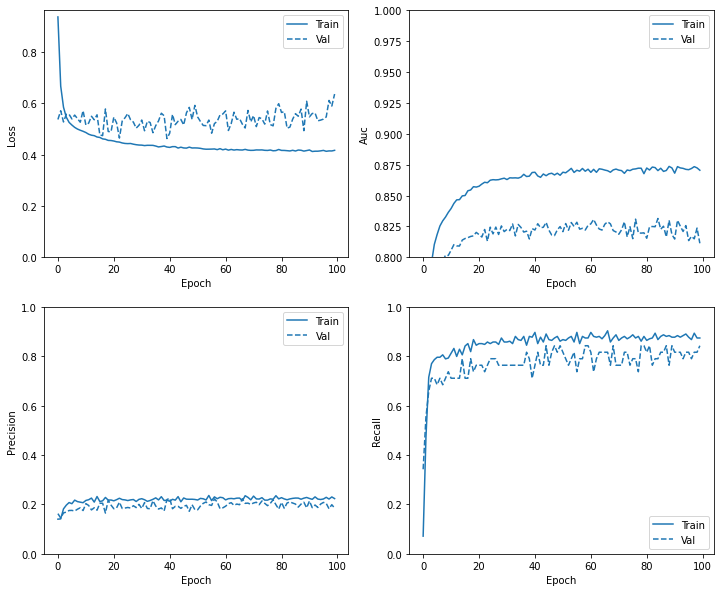

In [26]:
plot_metrics(model_hist)

Weighting the classes has produced a lower accuracy, but much higher recall score. For this project I am looking for a higher recall so this is ok. _Rahul said this is artificially increasing the recall and not improving the accuracy of the model to the data.  This is shown by the lack of improvement in the AUC._ 
___
Now I will try oversampling to create a balanced dataset which should be a smoother gradient descent to an optimization solution.

In [27]:
pos_indxs = train_targets == 1
pos_indxs = pos_indxs.reshape(-1,)

pos_inputs = train_inputs[pos_indxs]
neg_inputs = train_inputs[~pos_indxs]

pos_labels = train_targets[pos_indxs]
neg_labels = train_targets[~pos_indxs]


In [28]:
buffer_size = 10000
def make_ds(features,labels):
    ds = tf.data.Dataset.from_tensor_slices((features,labels))
    ds = ds.shuffle(buffer_size).repeat()
    return ds

pos_ds = make_ds(pos_inputs,pos_labels)
neg_ds = make_ds(neg_inputs,neg_labels)
                 

In [47]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds,neg_ds],\
                                                         weights = [.5,.5])
resampled_ds = resampled_ds.batch(batch_size).prefetch(2)

Actually the `sample_from_datasets` function appears to undersample the data.  Instead of oversampling the minority class the it is undersampling the majority class to create a balanced data set _Need to Confirm_

In [53]:
for features, label in resampled_ds.take(3):
  print(label.numpy().mean())

0.57
0.52
0.5


That is very close to 0.5.  The data set is now balanced by oversampling the positive cases.

In [54]:
resampled_steps_per_epoch = np.ceil(2.0*neg/batch_size)
resampled_steps_per_epoch

68.0

In [55]:
batch_size = 100
epochs = 100

width = 50
depth = 2

output_size = 1

activation = 'relu'

patience = 2

#inital_bias_output_layer = np.array([np.log(pos/neg)])
#inital_bias_output_layer = tf.keras.initializers.Constant(inital_bias_output_layer)

val_ds = tf.data.Dataset.from_tensor_slices((validation_inputs,validation_targets)).cache()
val_ds = val_ds.batch(batch_size).prefetch(2)


metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,\
                                       restore_best_weights = True)

oversamp_model = tf.keras.Sequential()

for _ in range(depth):
    oversamp_model.add(tf.keras.layers.Dense(width, activation = activation))

oversamp_model.add(tf.keras.layers.Dense(output_size, activation = 'sigmoid'))
                               

oversamp_model.compile(optimizer = 'Adam', loss = tf.keras.losses.BinaryCrossentropy(),\
             metrics = metrics)


oversamp_hist = oversamp_model.fit(resampled_ds, batch_size=batch_size,
         epochs = epochs, validation_data = (val_ds),
         steps_per_epoch = resampled_steps_per_epoch,
         verbose=2)



Epoch 1/100
68/68 - 2s - loss: 0.5892 - accuracy: 0.7078 - precision: 0.6858 - recall: 0.7667 - auc: 0.7661 - prc: 0.7273 - val_loss: 0.5790 - val_accuracy: 0.6667 - val_precision: 0.1588 - val_recall: 0.7105 - val_auc: 0.7610 - val_prc: 0.2348
Epoch 2/100
68/68 - 0s - loss: 0.5098 - accuracy: 0.7471 - precision: 0.7164 - recall: 0.8123 - auc: 0.8217 - prc: 0.7795 - val_loss: 0.5337 - val_accuracy: 0.6818 - val_precision: 0.1615 - val_recall: 0.6842 - val_auc: 0.7900 - val_prc: 0.3767
Epoch 3/100
68/68 - 0s - loss: 0.4854 - accuracy: 0.7666 - precision: 0.7343 - recall: 0.8394 - auc: 0.8391 - prc: 0.8025 - val_loss: 0.5203 - val_accuracy: 0.6883 - val_precision: 0.1646 - val_recall: 0.6842 - val_auc: 0.7978 - val_prc: 0.3756
Epoch 4/100
68/68 - 0s - loss: 0.4749 - accuracy: 0.7704 - precision: 0.7353 - recall: 0.8378 - auc: 0.8462 - prc: 0.8072 - val_loss: 0.5186 - val_accuracy: 0.6970 - val_precision: 0.1731 - val_recall: 0.7105 - val_auc: 0.8104 - val_prc: 0.3976
Epoch 5/100
68/68 - 

Epoch 35/100
68/68 - 0s - loss: 0.4064 - accuracy: 0.8090 - precision: 0.7751 - recall: 0.8767 - auc: 0.8760 - prc: 0.8461 - val_loss: 0.5969 - val_accuracy: 0.7056 - val_precision: 0.1937 - val_recall: 0.8158 - val_auc: 0.8210 - val_prc: 0.3393
Epoch 36/100
68/68 - 0s - loss: 0.4102 - accuracy: 0.8043 - precision: 0.7700 - recall: 0.8699 - auc: 0.8737 - prc: 0.8442 - val_loss: 0.5347 - val_accuracy: 0.7381 - val_precision: 0.2098 - val_recall: 0.7895 - val_auc: 0.8205 - val_prc: 0.3441
Epoch 37/100
68/68 - 0s - loss: 0.4042 - accuracy: 0.8101 - precision: 0.7770 - recall: 0.8776 - auc: 0.8774 - prc: 0.8476 - val_loss: 0.5768 - val_accuracy: 0.7273 - val_precision: 0.2067 - val_recall: 0.8158 - val_auc: 0.8192 - val_prc: 0.3285
Epoch 38/100
68/68 - 0s - loss: 0.4099 - accuracy: 0.8066 - precision: 0.7707 - recall: 0.8798 - auc: 0.8732 - prc: 0.8457 - val_loss: 0.5505 - val_accuracy: 0.7338 - val_precision: 0.2069 - val_recall: 0.7895 - val_auc: 0.8264 - val_prc: 0.3597
Epoch 39/100
68/

Epoch 69/100
68/68 - 0s - loss: 0.4010 - accuracy: 0.8104 - precision: 0.7744 - recall: 0.8743 - auc: 0.8782 - prc: 0.8454 - val_loss: 0.5937 - val_accuracy: 0.7338 - val_precision: 0.2028 - val_recall: 0.7632 - val_auc: 0.8152 - val_prc: 0.3071
Epoch 70/100
68/68 - 0s - loss: 0.4053 - accuracy: 0.8043 - precision: 0.7644 - recall: 0.8756 - auc: 0.8748 - prc: 0.8402 - val_loss: 0.6003 - val_accuracy: 0.7078 - val_precision: 0.1950 - val_recall: 0.8158 - val_auc: 0.8055 - val_prc: 0.3233
Epoch 71/100
68/68 - 0s - loss: 0.4030 - accuracy: 0.8071 - precision: 0.7670 - recall: 0.8776 - auc: 0.8779 - prc: 0.8447 - val_loss: 0.5749 - val_accuracy: 0.7597 - val_precision: 0.2296 - val_recall: 0.8158 - val_auc: 0.8195 - val_prc: 0.3338
Epoch 72/100
68/68 - 0s - loss: 0.4000 - accuracy: 0.8075 - precision: 0.7703 - recall: 0.8704 - auc: 0.8781 - prc: 0.8449 - val_loss: 0.5891 - val_accuracy: 0.7381 - val_precision: 0.2098 - val_recall: 0.7895 - val_auc: 0.8189 - val_prc: 0.3346
Epoch 73/100
68/

In [56]:
results = oversamp_model.evaluate(validation_inputs, validation_targets,\
                         batch_size = batch_size, verbose = 0)

In [57]:
for m,r in zip(oversamp_model.metrics_names,results):
    print(str(m)+': {:.3f}'.format(r))

loss: 0.595
accuracy: 0.742
precision: 0.209
recall: 0.763
auc: 0.819
prc: 0.337


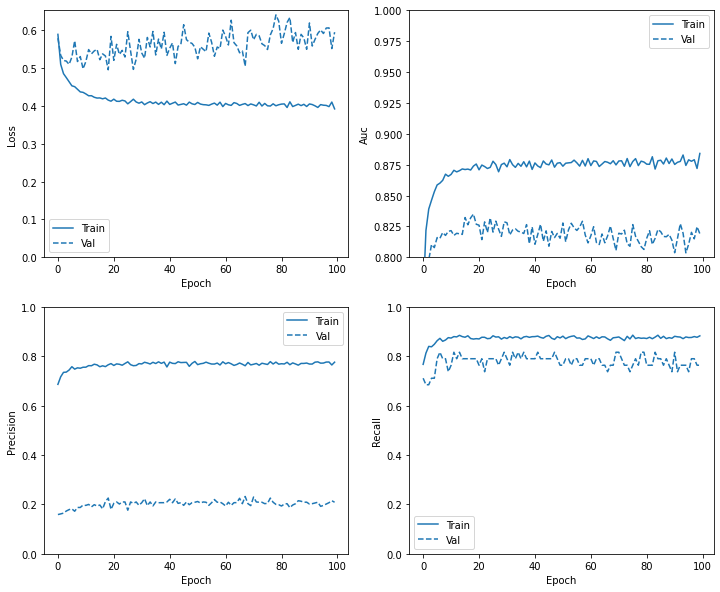

In [58]:
plot_metrics(oversamp_hist)

Now I will do a bit of tuning on the oversampled NN model.

In [91]:
batch_size = 500
epochs = 100

width = 128
depth = 8

output_size = 1

activation = 'relu'

patience = 5

resampled_steps_per_epoch = np.ceil(2.0*neg/batch_size)
resampled_steps_per_epoch

#inital_bias_output_layer = np.array([np.log(pos/neg)])
#inital_bias_output_layer = tf.keras.initializers.Constant(inital_bias_output_layer)

val_ds = tf.data.Dataset.from_tensor_slices((validation_inputs,validation_targets)).cache()
val_ds = val_ds.batch(batch_size).prefetch(2)


metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR')]

early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,\
                                       restore_best_weights = True)

oversamp_model = tf.keras.Sequential()

for _ in range(depth):
    oversamp_model.add(tf.keras.layers.Dense(width, activation = activation))

oversamp_model.add(tf.keras.layers.Dropout(.5))    
oversamp_model.add(tf.keras.layers.Dense(output_size, activation = 'sigmoid'))
                               

oversamp_model.compile(optimizer = 'Adam', loss = tf.keras.losses.BinaryCrossentropy(),\
             metrics = metrics)


oversamp_hist = oversamp_model.fit(resampled_ds, batch_size=batch_size,
         epochs = epochs, validation_data = (val_ds),
         steps_per_epoch = resampled_steps_per_epoch,
         callbacks = [early_stop],
         verbose=2)



Epoch 1/100
14/14 - 2s - loss: 0.6623 - accuracy: 0.6493 - precision: 0.6214 - recall: 0.7460 - auc: 0.7042 - prc: 0.6724 - val_loss: 0.6416 - val_accuracy: 0.7208 - val_precision: 0.1727 - val_recall: 0.6316 - val_auc: 0.7343 - val_prc: 0.2617
Epoch 2/100
14/14 - 0s - loss: 0.5559 - accuracy: 0.7407 - precision: 0.7390 - recall: 0.7667 - auc: 0.7900 - prc: 0.7659 - val_loss: 0.4736 - val_accuracy: 0.7078 - val_precision: 0.1655 - val_recall: 0.6316 - val_auc: 0.7694 - val_prc: 0.3156
Epoch 3/100
14/14 - 0s - loss: 0.5108 - accuracy: 0.7550 - precision: 0.7165 - recall: 0.8426 - auc: 0.8148 - prc: 0.7708 - val_loss: 0.5117 - val_accuracy: 0.6818 - val_precision: 0.1775 - val_recall: 0.7895 - val_auc: 0.7845 - val_prc: 0.2920
Epoch 4/100
14/14 - 0s - loss: 0.4761 - accuracy: 0.7886 - precision: 0.7296 - recall: 0.8953 - auc: 0.8398 - prc: 0.7814 - val_loss: 0.5314 - val_accuracy: 0.7143 - val_precision: 0.1987 - val_recall: 0.8158 - val_auc: 0.7972 - val_prc: 0.2319
Epoch 5/100
14/14 - 

In [92]:
results = oversamp_model.evaluate(val_ds,\
                         batch_size = batch_size, verbose = 0)

In [93]:
print('Validation Set scores')
for m,r in zip(oversamp_model.metrics_names,results):
    print(str(m)+': {:.3f}'.format(r))

Validation Set scores
loss: 0.474
accuracy: 0.708
precision: 0.166
recall: 0.632
auc: 0.769
prc: 0.316


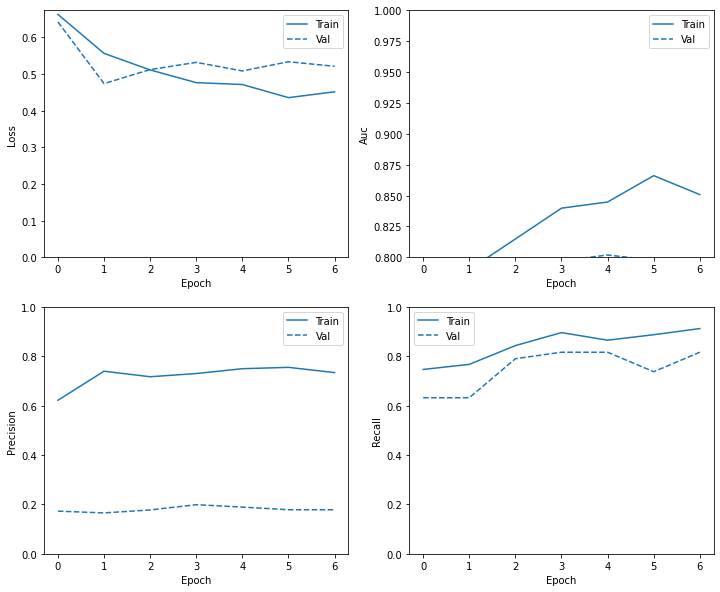

In [94]:
plot_metrics(oversamp_hist)

In [95]:
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs,test_targets)).cache()
test_ds = test_ds.batch(batch_size).prefetch(2)

In [96]:
test_results = oversamp_model.evaluate(test_ds,batch_size=batch_size)
print('Final Test Scores:')
for m,r in zip(oversamp_model.metrics_names,test_results):
    print(str(m)+': {:.3f}'.format(r))

1/1 [==============================] - 0s 11ms/step - loss: 0.4593 - accuracy: 0.7316 - precision: 0.2185 - recall: 0.8462 - auc: 0.8175 - prc: 0.1924
Final Test Scores:
loss: 0.459
accuracy: 0.732
precision: 0.219
recall: 0.846
auc: 0.817
prc: 0.192


This model performs about as well as on the test set as the XGBoost model that I chose for my project.  